In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np


from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


from model import ModelArgs, TransformerForSequenceClassification

import os

device = "cuda" if torch.cuda.is_available() else 'cpu'

In [2]:
df = pd.read_csv("../data/data_with_scaled_grades.csv")
df = df[["essay", "scaled_grade"]]
def let_to_num(row):
    k = {"F": 0, "D": 1, "C": 2, "B": 3, "A": 4}
    return k[row]


df["num_grade"] = df["scaled_grade"].apply(let_to_num)

tr = round(len(df) * 0.8)
val = round(len(df) * 0.1)

df_train = df[0:tr]
df_val = df[tr : tr + val]
df_test = df[tr + val :]

In [3]:
if not os.path.exists('tokenizer.json'):
    x = df["essay"]

    trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"],vocab_size=30000)

    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

    tokenizer.pre_tokenizer = Whitespace()

    tokenizer.train_from_iterator(x, trainer=trainer)


    tokenizer.save("tokenizer.json")
else:
    tokenizer = Tokenizer.from_file('tokenizer.json')
    

In [4]:
class EssayDataset(Dataset):
    def __init__(self, essay_df, tokenizer, max_len):

        self.essays = []
        self.scores = []

        for essay, score in zip(essay_df["essay"], essay_df["num_grade"]):
            encoded = tokenizer.encode(essay)
            if len(encoded.ids) <= max_len:
                self.essays.append(essay)
                self.scores.append(score)

        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, index):
        essay = self.essays[index]
        encoded = self.tokenizer.encode(essay)
        score = self.scores[index]

        input_ids = torch.tensor(encoded.ids, dtype=torch.long) 

        return {
            input_ids,
            torch.tensor([score], dtype=torch.long),
        }

    def num_classes(self):
        return pd.Series(self.scores).nunique()

    def __repr__(self) -> str:
        return f"Dataset with {len(self)} essays"


ds_train = EssayDataset(df_train, tokenizer, 1024)
ds_val = EssayDataset(df_val, tokenizer, 1024)

In [5]:

config = ModelArgs(
   dim=768,
   n_layers=40,
   n_heads=32,
   vocab_size=tokenizer.get_vocab_size(),
    n_classes=ds_train.num_classes(),
)

model = TransformerForSequenceClassification(config)
print(f"{model.params():,}")

state_dict = torch.load('weights/model_epoch_20.pt')
model.load_state_dict(state_dict)

model = model.to(device)


306,221,573


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=2)

from torch.nn.utils.rnn import pad_sequence
import torch


def collate_batch(batch):
    data, labels = zip(*batch)

    padded_data = pad_sequence(
        data, batch_first=True, padding_value=0
    )  

    labels = torch.tensor(labels)

    return padded_data, labels

train_dataloader = DataLoader(ds_train, batch_size=1, shuffle=True, drop_last=True, collate_fn=collate_batch)
val_dataloader = DataLoader(ds_val, batch_size=1, shuffle=True, drop_last=True, collate_fn=collate_batch)


In [8]:
start_epoch = 1
end_epoch = 20
batch_losses = []
val_losses = []
val_accuracies = []
for epoch in range(start_epoch,end_epoch):
    torch.cuda.empty_cache()
    model.train()
    batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
    running_loss = 0.0
    for batch_idx,batch in enumerate(batch_iterator):
        tokens,labels = batch[0].to(device),batch[1].to(device)
        out = model(tokens)
        loss = loss_fn(out, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_losses.append(running_loss /( 1 if batch_idx == 0 else batch_idx))

        running_loss += loss.item()

        batch_iterator.set_postfix(loss=running_loss /( 1 if batch_idx == 0 else batch_idx))
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        val_iterator = tqdm(val_dataloader,desc=f"Validating Epoch {epoch:02d}")
        for idx,batch in enumerate(val_iterator):
            tokens,labels = batch[0].to(device),batch[1].to(device)
            out = model(tokens)
            loss = loss_fn(out,labels)

            val_loss += loss.item()

            preds = torch.argmax(out, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            preds = torch.argmax(out, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_losses.append(loss.item())
            val_accuracies.append(val_correct / val_total)

    scheduler.step(val_loss)


    val_loss /= len(val_dataloader)
    val_accuracy = val_correct / val_total

    torch.save(model.state_dict(), os.path.join('weights', f'model_epoch_{epoch+1}.pt'))

    print(
        f"Epoch [{epoch+1}/{end_epoch}], Train Loss: {running_loss / len(train_dataloader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
    )


Validating Epoch 04: 100%|██████████| 1298/1298 [00:27<00:00, 46.96it/s]


Epoch [5/20], Train Loss: 1.0582, Val Loss: 1.4480, Val Accuracy: 0.3760


Validating Epoch 05: 100%|██████████| 1298/1298 [00:27<00:00, 46.92it/s]


Epoch [6/20], Train Loss: 1.0353, Val Loss: 1.4605, Val Accuracy: 0.4461


Validating Epoch 06: 100%|██████████| 1298/1298 [00:27<00:00, 46.95it/s]


Epoch [7/20], Train Loss: 0.9937, Val Loss: 1.3494, Val Accuracy: 0.4638


Validating Epoch 07: 100%|██████████| 1298/1298 [00:27<00:00, 46.92it/s]


Epoch [8/20], Train Loss: 0.9068, Val Loss: 1.3711, Val Accuracy: 0.4615


Validating Epoch 08: 100%|██████████| 1298/1298 [00:27<00:00, 46.94it/s]


Epoch [9/20], Train Loss: 0.8768, Val Loss: 1.4069, Val Accuracy: 0.4684


Validating Epoch 09: 100%|██████████| 1298/1298 [00:27<00:00, 46.93it/s]


Epoch [10/20], Train Loss: 0.8507, Val Loss: 1.4249, Val Accuracy: 0.4676


Validating Epoch 10: 100%|██████████| 1298/1298 [00:27<00:00, 46.92it/s]


Epoch [11/20], Train Loss: 0.8235, Val Loss: 1.4091, Val Accuracy: 0.4630


Validating Epoch 11: 100%|██████████| 1298/1298 [00:30<00:00, 41.99it/s]


Epoch [12/20], Train Loss: 0.8119, Val Loss: 1.4116, Val Accuracy: 0.4661


Validating Epoch 12: 100%|██████████| 1298/1298 [00:27<00:00, 46.93it/s]


Epoch [13/20], Train Loss: 0.8025, Val Loss: 1.4145, Val Accuracy: 0.4684


Validating Epoch 13: 100%|██████████| 1298/1298 [00:27<00:00, 46.94it/s]


Epoch [14/20], Train Loss: 0.7934, Val Loss: 1.4140, Val Accuracy: 0.4638


Validating Epoch 14: 100%|██████████| 1298/1298 [00:27<00:00, 46.93it/s]


Epoch [15/20], Train Loss: 0.7911, Val Loss: 1.4142, Val Accuracy: 0.4638


Validating Epoch 15: 100%|██████████| 1298/1298 [00:27<00:00, 46.94it/s]


Epoch [16/20], Train Loss: 0.7893, Val Loss: 1.4152, Val Accuracy: 0.4630


Validating Epoch 16: 100%|██████████| 1298/1298 [00:27<00:00, 46.96it/s]


Epoch [17/20], Train Loss: 0.7876, Val Loss: 1.4155, Val Accuracy: 0.4630


Validating Epoch 17: 100%|██████████| 1298/1298 [00:27<00:00, 46.94it/s]


Epoch [18/20], Train Loss: 0.7873, Val Loss: 1.4157, Val Accuracy: 0.4630


Validating Epoch 18: 100%|██████████| 1298/1298 [00:27<00:00, 46.85it/s]


Epoch [19/20], Train Loss: 0.7871, Val Loss: 1.4160, Val Accuracy: 0.4630


Validating Epoch 19: 100%|██████████| 1298/1298 [00:27<00:00, 46.88it/s]


Epoch [20/20], Train Loss: 0.7868, Val Loss: 1.4159, Val Accuracy: 0.4630


In [7]:
ds_test = EssayDataset(df_test, tokenizer, 1024)

In [ ]:
preds = []
labels = []
for i in tqdm(range(len(ds_test))):
    tokens, label = ds_test[i]
    out = model(tokens.unsqueeze(0).to(device))
    pred = torch.argmax(out)
    out = out.to('cpu')
    del out

    preds.append(pred)
    labels.append(label)


In [9]:
preds = torch.stack(preds).cpu().numpy()
labels = torch.stack(labels).squeeze().numpy()

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(labels,preds)

In [23]:
from sklearn.metrics import classification_report
report = classification_report(labels, preds, target_names=["f","d","c",'b','a'])

print(report)

              precision    recall  f1-score   support

           f       0.50      0.02      0.04        53
           d       0.43      0.12      0.18       383
           c       0.43      0.44      0.43       334
           b       0.26      0.33      0.29       370
           a       0.06      0.19      0.09       117

    accuracy                           0.27      1257
   macro avg       0.34      0.22      0.21      1257
weighted avg       0.35      0.27      0.27      1257



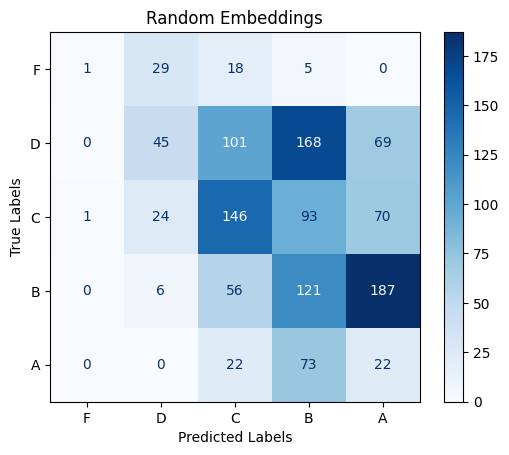

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["F", "D", "C", "B", "A"])

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax) 

ax.set_title('Random Embeddings')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [6]:

def quadratic_weighted_kappa(conf_matrix):

    w = np.zeros_like(conf_matrix, dtype=float)

    num_categories = conf_matrix.shape[0] 

    for i in range(num_categories):
        for j in range(num_categories):
            w[i, j] = ((i - j) / (num_categories - 1)) ** 2


    total_observations = conf_matrix.sum()

    row_totals = conf_matrix.sum(axis=1)

    col_totals = conf_matrix.sum(axis=0)

    e = np.zeros_like(conf_matrix, dtype=float)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            e[i, j] = (row_totals[i] * col_totals[j]) / total_observations


    num = 0
    den = 0
    for i in range(num_categories):
        for j in range(num_categories):
            num += (w[i,j] * conf_matrix[i,j])
            den += (w[i,j] * e[i,j])

    return 1 - (num/den)

In [21]:
quadratic_weighted_kappa(conf_matrix)

0.2608982054803327